#### Generate an end to end Langgraph Application for automating the workflow of Blog Generation using open source LLM models and make sure to debug with the help of Langsmith(Attach the zip file and explain your fundamental approach )

#### 2.Generate an end to end Langgraph Application for automating the workflow of Coding Peer Reviews using open source LLM models and make sure to debug with the help of Langsmith(Attach the zip file and explain your fundamental approach )

#### 3.Generate an end to end Langgraph Application for automating the workflow of the architecture of orchestrator and synthesizer(Think of different usecase) using open source LLM models and make sure to debug with the help of Langsmith(Attach the zip file and explain your fundamental approach an dproblem statement )

## Codine Peer Review Agent

In [137]:
from dotenv import load_dotenv
import os

# Load variables from .env file into environment
load_dotenv()

True

In [138]:
import os 
API_KEYS = ['GROQ_API_KEY','GROQ_YOUTUBE_COLLAB','HUGGINGFACE_TOKEN','LANGCHAIN_API_KEY','LANGCHAIN_PROJECT','HF_TOKEN','GOOGLE_API_KEY']
for k in API_KEYS:
    value = os.getenv(k)
    if value:
        os.environ[k] = value
        print(f"{k} loaded successfully.")
    else:
        print(f"{k} not found in .env or environment.")

GROQ_API_KEY loaded successfully.
GROQ_YOUTUBE_COLLAB loaded successfully.
HUGGINGFACE_TOKEN loaded successfully.
LANGCHAIN_API_KEY loaded successfully.
LANGCHAIN_PROJECT loaded successfully.
HF_TOKEN loaded successfully.
GOOGLE_API_KEY loaded successfully.


In [139]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model='Llama3-8b-8192',
)

In [140]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel

In [141]:
from pydantic import BaseModel

class ChatState(BaseModel):
    user_input: str = ""        # Problem statement or task description
    code: str = ""              # Generated code
    test_cases: str = ""        # Generated test cases
    output_file: str = ""       # Output file path or name
    review: str = ""            # Evaluation report from evaluator agent
    documentation: str = ""    # Generated documentation
    manager: str = ""           # Manager decision


In [142]:
def generate_code_agent(state: ChatState) -> str:
    """
    Generates production-ready code for the problem described in `state.user_input`.
    
    This function is part of a **parallel orchestrator pipeline**, working alongside:
      - `generate_test_cases_agent` (test generation)
      - `generate_documentation_agent` (documentation creation)
    
    The generated code will:
      - Adhere to the language specified in the user's request (if given).
      - Follow clean, maintainable coding practices.
      - Include error handling and edge case coverage.
    
    Args:
        state (ChatState): Shared conversation state containing the user problem description.
    
    Returns:
        str: The generated code as a string.
    """
    prompt = f"""
    You are a code-generation agent in a parallel orchestrator system.
    Your task is to write **production-grade, well-documented code** to solve the following problem:
    
    Problem Statement:
    {state.user_input}
    
    Requirements:
    - Use the programming language mentioned in the problem, if specified. 
      If no language is mentioned, default to Python.
    - Ensure the code is clean, readable, and maintainable.
    - Add comments explaining key logic steps.
    - Include input validation and handle edge cases gracefully.
    - Avoid unnecessary complexity — keep it efficient.
    
    Output only the complete code, no explanations.
    """
    task = llm.invoke(prompt)
    return {
        "code": task.content,
    }

In [143]:
def generate_test_cases_agent(state: ChatState) -> str:
    """
    Generates comprehensive test cases for the code produced by `generate_code_agent`.
    
    Works in the same **parallel orchestrator** as `generate_code_agent` and `generate_documentation_agent`.
    Ensures that the tests validate correctness, edge case handling, and performance constraints.
    
    Args:
        state (ChatState): Shared conversation state containing the user problem description.
    
    Returns:
        str: Test cases in the same programming language as the generated code.
    """
    prompt = f"""
    You are a test-case generation agent in a parallel orchestrator system.
    Your task is to produce a **comprehensive set of test cases** for the solution to the following problem:
    
    Problem Statement:
    {state.user_input}
    
    Requirements:
    - Use the **same programming language** as the code from `generate_code_agent`.
    - Cover normal, boundary, and edge cases.
    - Include both positive and negative test scenarios.
    - Ensure tests are self-contained and runnable.
    - Where applicable, include automated unit tests using the language's standard testing framework.
    
    Output only the test code, no explanations.
    """
    task = llm.invoke(prompt)
    return {
        "test_cases": task.content,
    }

In [144]:
def generate_documentation_agent(state: ChatState) -> str:
    """
    Generates clear and structured documentation for the code solving `state.user_input`.
    
    This function runs in the **parallel orchestrator** alongside:
      - `generate_code_agent` (solution generation)
      - `generate_test_cases_agent` (test generation)
    
    Documentation will include:
      - Problem summary
      - Inputs and outputs
      - Assumptions
      - Example usage
    
    Args:
        state (ChatState): Shared conversation state containing the user problem description.
    
    Returns:
        str: Documentation in Markdown format.
    """
    prompt = f"""
    You are a documentation-generation agent in a parallel orchestrator system.
    Your task is to write **clear, user-friendly documentation** for the solution to the following problem:
    
    Problem Statement:
    {state.user_input}
    
    Requirements:
    - Use Markdown format.
    - Include a short problem description.
    - Document function/class parameters, return values, and exceptions.
    - Add at least one example usage.
    - Mention any important constraints or assumptions.
    - Keep it concise but complete.
    
    Output only the documentation, no explanations.
    """
    task = llm.invoke(prompt)
    return {
        "documentation": task.content,
    }

In [ ]:
def combine_all_file(state: ChatState) -> str:
    """
    Combines all generated outputs into a single output file.
    
    Args:
        state (ChatState): The shared state containing generated content.

    Returns:
        str: Combined content string containing problem statement, code, test cases, and documentation.
    """
    combine = ""
    combine += f"Here is the complete file about {state.user_input}!\n\n"
    combine += f"# Problem Statement: {state.user_input}\n\n"
    combine += f"# Generated Code:\n{state.code}\n\n"
    combine += f"# Test Cases:\n{state.test_cases}\n\n"
    combine += f"# Documentation:\n{state.documentation}\n\n"
    return combine


In [146]:
def evaluator_agent(state: ChatState) -> str:
    """
    Evaluates the generated code, test cases, and documentation for the problem in `state.user_input`.
    
    This agent is part of the **parallel/serial orchestrator pipeline** and comes after:
      - `generate_code_agent` (produces the main solution)
      - `generate_test_cases_agent` (produces tests for the solution)
      - `generate_documentation_agent` (produces docs for the solution)
    
    The evaluator:
      - Reviews whether the code solves the given problem correctly.
      - Checks completeness and maintainability.
      - Ensures the test cases adequately cover edge cases and possible failure scenarios.
      - Verifies that the documentation is accurate and clear.
      - Suggests improvements for performance, clarity, and robustness.
    
    Args:
        state (ChatState): Shared conversation state containing the problem statement, generated code, 
                           test cases, and documentation.
    
    Returns:
        str: A structured evaluation and review report.
    """
    prompt = f"""
    You are a code evaluator agent in an orchestrator system.
    Your job is to review and evaluate the following solution to the given problem.

    Problem Statement:
    {state.user_input}

    Generated Code:
    {state.code}

    Generated Test Cases:
    {state.test_cases}

    Generated Documentation:
    {state.documentation}

    Evaluation Requirements:
    - Assess **correctness**: Does the code solve the problem as stated?
    - Assess **completeness**: Are all required features and constraints addressed?
    - Assess **code quality**: Maintainability, readability, and adherence to best practices.
    - Assess **test coverage**: Do the test cases check normal, boundary, and error conditions?
    - Assess **documentation quality**: Clarity, accuracy, and helpfulness.
    - Identify **edge cases** not covered in the code or tests.
    - Provide **specific improvement suggestions**.
    - Rate each category on a scale of 1–10.

    Output a structured review in the following format:
    ---
    **Evaluation Report**
    Correctness: X/10 - <comments>
    Completeness: X/10 - <comments>
    Code Quality: X/10 - <comments>
    Test Coverage: X/10 - <comments>
    Documentation: X/10 - <comments>
    Suggested Improvements:
    - Point 1
    - Point 2
    - ...
    ---
    """
    task = llm.invoke(prompt)
    return {
        "review": task.content,
    }

In [147]:
def manager_agent(state: ChatState) -> str:
    """
    Acts as the decision-making agent in the orchestrator.
    
    This agent receives the evaluation report from `evaluator_agent` and decides
    which agent (code, test cases, or evaluator) should revise their work based on the review.
    
    Decision logic:
      - If correctness or completeness is below the threshold → Send back to `generate_code_agent`.
      - If test coverage is below the threshold → Send back to `generate_test_cases_agent`.
      - If the evaluation report is inconsistent or incomplete → Send back to `evaluator_agent`.
      - If all scores meet or exceed thresholds → Approve and mark task as complete.
    
    Args:
        state (ChatState): Shared conversation state containing:
                           - `user_input`
                           - `review` (evaluation report from evaluator_agent)
                           - Other generated artifacts for context
    
    Returns:
        str: A management decision in the following format:
             ---
             **Manager Decision**
             Action: <Which agent to send back to or APPROVED>
             Reason: <Reason for the decision>
             ---
    """
    prompt = f"""
    You are the manager agent in a multi-agent orchestrator system.
    You receive the following evaluation report from the evaluator agent:

    Evaluation Report:
    {state.review}

    Your task is to:
    - Read the scores and comments carefully.
    - If **Correctness** < 8 or **Completeness** < 8 → Action = SEND_BACK_TO_CODE_AGENT.
    - If **Test Coverage** < 8 → Action = SEND_BACK_TO_TEST_CASES_AGENT.
    - If the evaluation report is unclear, incomplete, or contradictory → Action = SEND_BACK_TO_EVALUATOR_AGENT.
    - If all scores are >= 8 and there are no major issues → Action = APPROVED.

    Output only in the following format:
    ---
    **Manager Decision**
    Action: <SEND_BACK_TO_CODE_AGENT / SEND_BACK_TO_TEST_CASES_AGENT / SEND_BACK_TO_EVALUATOR_AGENT / APPROVED>
    Reason: <Brief reason for decision>
    ---
    """
    task = llm.invoke(prompt)
    return {
        "manager": task.content,
    }


In [148]:
def llm_call_router(state: ChatState):
    """
    Routes the workflow to the correct agent based on the Manager's decision.

    This function acts as the orchestrator router using the Manager Agent's logic.
    It reads the evaluator's review (state.review) and decides whether to:
        - Send back to `generate_code_agent`
        - Send back to `generate_test_cases_agent`
        - Send back to `evaluator_agent`
        - Approve the work and finish

    Args:
        state (ChatState): The shared conversation state containing:
                           - user_input
                           - review (evaluation report from evaluator_agent)
                           - other relevant artifacts (code, test_cases, documentation)

    Returns:
        dict: Contains the manager's decision and reason.
              Example:
              {
                  "manager": "**Manager Decision**\nAction: SEND_BACK_TO_CODE_AGENT\nReason: Low correctness score"
              }
    """
    decision_prompt = f"""
    You are the manager agent in a multi-agent orchestrator system.
    You receive the following evaluation report from the evaluator agent:

    Evaluation Report:
    {state.review}

    Your task is to:
    - Read the scores and comments carefully.
    - If **Correctness** < 8 or **Completeness** < 8 → Action = SEND_BACK_TO_CODE_AGENT.
    - If **Test Coverage** < 8 → Action = SEND_BACK_TO_TEST_CASES_AGENT.
    - If the evaluation report is unclear, incomplete, or contradictory → Action = SEND_BACK_TO_EVALUATOR_AGENT.
    - If all scores are >= 8 and there are no major issues → Action = APPROVED.

    Output only in the following format:
    ---
    **Manager Decision**
    Action: <SEND_BACK_TO_CODE_AGENT / SEND_BACK_TO_TEST_CASES_AGENT / SEND_BACK_TO_EVALUATOR_AGENT / APPROVED>
    Reason: <Brief reason for decision>
    ---
    """

    # Call the LLM router to get the manager's decision
    task = router.invoke([
        SystemMessage(content="You are the Manager Agent. Make a routing decision based on the evaluation report."),
        HumanMessage(content=decision_prompt)
    ])

    # Return structured decision
    return {
        "manager": task.content
    }


In [149]:
def route_decision(state: ChatState):
    """
    Decide which node to visit next based on the manager's decision.

    Expected `state.manager` format:
    ---
    **Manager Decision**
    Action: <SEND_BACK_TO_CODE_AGENT / SEND_BACK_TO_TEST_CASES_AGENT / SEND_BACK_TO_EVALUATOR_AGENT / APPROVED>
    Reason: <Brief reason>
    ---

    Returns:
        str: Name of the next node in the LangGraph pipeline.
    """
    decision_text = (state.manager or "").upper()

    if "SEND_BACK_TO_CODE_AGENT" in decision_text:
        return "generate_code_agent"
    elif "SEND_BACK_TO_TEST_CASES_AGENT" in decision_text:
        return "generate_test_cases_agent"
    elif "SEND_BACK_TO_EVALUATOR_AGENT" in decision_text:
        return "evaluator_agent"
    elif "SEND_BACK_TO_DOCUMENTATION_AGENT" in decision_text:
        return "generate_documentation_agent"
    elif "APPROVED" in decision_text:
        return "end"  # Final node name for completion
    else:
        raise ValueError(f"Unknown manager decision: {state.manager}")


In [150]:
parallel_builder = StateGraph(ChatState)


In [151]:
parallel_builder.add_node('generate_code_agent', generate_code_agent)
parallel_builder.add_node('generate_test_cases_agent', generate_test_cases_agent)
parallel_builder.add_node('generate_documentation_agent', generate_documentation_agent)
parallel_builder.add_node('output_file', combine_all_file)
parallel_builder.add_node('evaluator_agent', evaluator_agent)
parallel_builder.add_node('manager_agent', manager_agent)
parallel_builder.add_node('llm_call_router', llm_call_router)

In [152]:
parallel_builder.add_edge(START, 'generate_code_agent')
parallel_builder.add_edge(START, 'generate_test_cases_agent')
parallel_builder.add_edge(START, 'generate_documentation_agent')

parallel_builder.add_edge('generate_code_agent', 'output_file')
parallel_builder.add_edge('generate_test_cases_agent', 'output_file')
parallel_builder.add_edge('generate_documentation_agent', 'output_file')
parallel_builder.add_edge('output_file','evaluator_agent')
parallel_builder.add_edge('evaluator_agent', 'manager_agent')
parallel_builder.add_edge('manager_agent', 'llm_call_router')
parallel_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "generate_code_agent": "generate_code_agent",
        "generate_test_cases_agent": "generate_test_cases_agent",
        "generate_documentation_agent": "generate_documentation_agent",
        "evaluator_agent": "evaluator_agent"
    }
)
parallel_builder.add_edge('manager_agent', END)



In [153]:
from IPython.display import Image,display
from langgraph.checkpoint.memory import MemorySaver

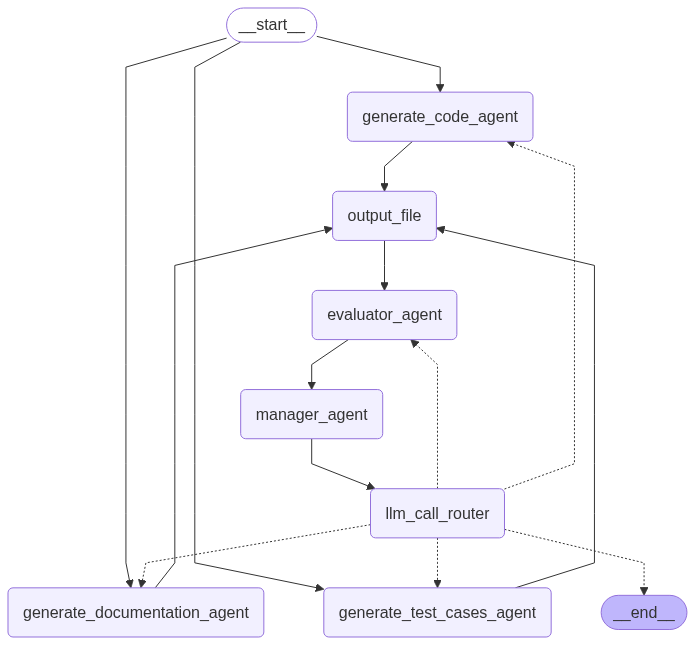

In [154]:
# Compile workflow
coder_agent = parallel_builder.compile()

# Show the workflow
display(Image(coder_agent.get_graph().draw_mermaid_png()))

In [155]:
state = coder_agent.invoke({
    "user_input" : "Write a function to calculate the factorial of a number in java"
    })
# for m in messages['messages']:
#   m.pretty_print()
    
print(state)

TypeError: 'ChatState' object is not subscriptable